<a href="https://colab.research.google.com/github/gikirima/UAS_ML/blob/main/Clustering_Berita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install kneed

In [71]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/gikirima/KlikBERT/refs/heads/main/KlikBERT_dataset.csv')
df.head()

,isi,judul,url,kategori_berita,clickbait_label
0,Beredar video [arsip] dari kanal YouTube “KAJI...,Jokowi Terseret Kasus Tom Lembong,https://turnbackhoax.id/2024/11/14/salah-jokow...,politik,misleading
1,Akun Instagram “singanuswantara” pada Senin (7...,Pandemic Treaty: Ada Denda untuk Masyarakat Pe...,https://turnbackhoax.id/2025/04/30/salah-pande...,politik,misleading
2,Beredar video [arsip] dari kanal YouTube “KAJI...,"Belum Seminggu Dilantik, Gibran Digugat PDIP",https://turnbackhoax.id/2024/10/29/salah-belum...,politik,misleading
3,Fakta soal isu Baharuddin Jusuf (BJ) BJ Habib...,"Viral Isu BJ Habibie Meninggal Dunia, RSPAD Le...",https://www.tribunnews.com/nasional/2019/09/10...,politik,misleading
4,Kanal YouTube “Sport news” pada Sabtu (11/1/20...,PSSI Terancam Dibekukan Usai Pecat Shin Tae-yong,https://turnbackhoax.id/2025/01/21/salah-pssi-...,politik,misleading


In [72]:
# buang kategori_berita dan clickbait_label
df = df.drop(['kategori_berita', 'clickbait_label','url'], axis=1)
df.describe()

,isi,judul
count,4117,4117
unique,2721,4116
top,Beauty,"Atasi Kabut Asap dari Indonesia, Malaysia Renc..."
freq,369,2


# Data Cleaning

In [73]:
# membersihkan data isi yang memiliki jumlah kata yang sedikit
df = df[df['isi'].apply(lambda x: len(x.split()) > 10)]
df.describe()

,isi,judul
count,2674,2674
unique,2674,2673
top,"di Pekanbaru, Riau, semakin parah. Status udar...","Atasi Kabut Asap dari Indonesia, Malaysia Renc..."
freq,1,2


In [74]:
import re

# Daftar pola/keyword dari sumber-sumber berita
keywords = [
    r"liputan6\.?com",  # .com is now optional
    r"fimela\.?com",   # .com is now optional
    r"kompas\.?com",    # .com is now optional
    r"turnbackhoax\.?id", # .id is now optional (already done)
    r"tirto\.?id",      # .id is now optional
    r"detik\.?com",     # .com is now optional
    r"tempo\.?co",      # .co is now optional
    r"sindonews\.?com", # .com is now optional
    r"okezone\.?com",   # .com is now optional
    r"artikel ini.*?tayang",
    r"baca juga:",
    r"penulis:",
    r"editor:",
    r"redaksi",
    r"\(.*?\d{4}.*?\)",
    r"cek fakta.*?",
    r"berita ini telah",
    r"copyright.*?\d{4}",
    r"sumber:.*?"
]

# Gabungkan jadi satu pola regex besar
pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)

# Fungsi pembersih isi (menghapus bagian yang cocok)
def bersihkan_isi_sub(text):
    # Ganti semua kecocokan pola dengan string kosong
    cleaned_text = pattern.sub('', text)
    # Optional: membersihkan spasi berlebih yang mungkin muncul setelah penghapusan
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Terapkan ke kolom 'isi'
df['isi'] = df['isi'].fillna('').apply(bersihkan_isi_sub)

In [75]:
df.head()

,isi,judul
0,Beredar video [arsip] dari kanal YouTube “KAJI...,Jokowi Terseret Kasus Tom Lembong
1,Akun Instagram “singanuswantara” pada Senin me...,Pandemic Treaty: Ada Denda untuk Masyarakat Pe...
2,Beredar video [arsip] dari kanal YouTube “KAJI...,"Belum Seminggu Dilantik, Gibran Digugat PDIP"
3,"Fakta soal isu Baharuddin Jusuf dinihari, vira...","Viral Isu BJ Habibie Meninggal Dunia, RSPAD Le..."
4,Kanal YouTube “Sport news” pada Sabtu mengungg...,PSSI Terancam Dibekukan Usai Pecat Shin Tae-yong


In [76]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from tqdm import tqdm
import numpy as np

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load tokenizer dan model IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)
model.eval()

# Fungsi untuk mendapatkan embeddings dalam batch
def get_embeddings_batch(texts):
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Mean pooling dari last hidden state
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# Proses batch untuk kolom tertentu
def embed_column(df, column_name, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(df), batch_size), desc=f"Embedding {column_name}"):
        batch_texts = df[column_name].iloc[i:i+batch_size].tolist()
        batch_embeddings = get_embeddings_batch(batch_texts)
        all_embeddings.extend(batch_embeddings)
    return np.array(all_embeddings)

# Proses untuk judul dan isi
df['judul_embeddings'] = list(embed_column(df, 'judul'))
df['isi_embeddings'] = list(embed_column(df, 'isi'))

# Contoh hasil
print(df[['judul', 'judul_embeddings']].head())


Using device: cuda


Embedding isi: 100%|██████████| 168/168 [01:22<00:00,  2.03it/s]

                                               judul  \
0                  Jokowi Terseret Kasus Tom Lembong   
1  Pandemic Treaty: Ada Denda untuk Masyarakat Pe...   
2       Belum Seminggu Dilantik, Gibran Digugat PDIP   
3  Viral Isu BJ Habibie Meninggal Dunia, RSPAD Le...   
4   PSSI Terancam Dibekukan Usai Pecat Shin Tae-yong   

                                    judul_embeddings  
0  [-0.19914494, 0.2598951, 0.74872625, -0.004822...  
1  [0.17183839, -0.10903659, 0.96897644, 0.805347...  
2  [-0.13695092, 0.4669672, 0.6071729, 0.2587525,...  
3  [0.13689502, 0.598, -0.10696524, -0.89159507, ...  
4  [-0.40197274, -0.61630803, 1.3731375, 0.996155...  


In [77]:
df.head()

,isi,judul,judul_embeddings,isi_embeddings
0,Beredar video [arsip] dari kanal YouTube “KAJI...,Jokowi Terseret Kasus Tom Lembong,"[-0.19914494, 0.2598951, 0.74872625, -0.004822...","[-0.35696846, 0.99044263, -0.22460005, -0.1977..."
1,Akun Instagram “singanuswantara” pada Senin me...,Pandemic Treaty: Ada Denda untuk Masyarakat Pe...,"[0.17183839, -0.10903659, 0.96897644, 0.805347...","[-0.18122186, 1.2522277, 0.57878137, 0.2105261..."
2,Beredar video [arsip] dari kanal YouTube “KAJI...,"Belum Seminggu Dilantik, Gibran Digugat PDIP","[-0.13695092, 0.4669672, 0.6071729, 0.2587525,...","[-0.24703373, 1.340805, -0.16723868, -0.098587..."
3,"Fakta soal isu Baharuddin Jusuf dinihari, vira...","Viral Isu BJ Habibie Meninggal Dunia, RSPAD Le...","[0.13689502, 0.598, -0.10696524, -0.89159507, ...","[-0.16841334, 0.9635866, 0.40052813, -0.203930..."
4,Kanal YouTube “Sport news” pada Sabtu mengungg...,PSSI Terancam Dibekukan Usai Pecat Shin Tae-yong,"[-0.40197274, -0.61630803, 1.3731375, 0.996155...","[-0.5579486, 1.2574483, 0.15410109, 0.41464287..."


In [78]:
import numpy as np

# Gabungkan embeddings dari judul dan isi
X = np.array([
    np.concatenate([judul_emb, isi_emb])
    for judul_emb, isi_emb in zip(df['judul_embeddings'], df['isi_embeddings'])
])

from sklearn.cluster import KMeans

# Tentukan jumlah kluster awal
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)
print(df['cluster'].value_counts())

cluster
3    800
4    611
1    601
2    438
0    224
Name: count, dtype: int64


In [79]:
for i in range(n_clusters):
    print(f"\nCluster {i}")
    print(df[df['cluster'] == i][['judul']].head(3))


Cluster 0
                                                 judul
939  Kekalahan dari Napoli Buat Liverpool Juara Lig...
940  Mengapa Mees Hilgers Tampil Buruk di Timnas In...
942  Komentator: Romelu Lukaku Baru Bisa Dikalahkan...

Cluster 1
                                                judul
3   Viral Isu BJ Habibie Meninggal Dunia, RSPAD Le...
27  Bom Waktu Hubungan Prabowo-Gibran, Relasi Kedu...
57  Ketik "Monyet Cukur Rambut" di Google, Muncul ...

Cluster 2
                                                judul
5   Video Pasukan Jet Israel Pulang dengan Selamat...
6             Sri Mulyani Berikan Bantuan Modal Usaha
13  Jadi Anggota DPR, Verrell Bramasta Bagi-Bagi R...

Cluster 3
                                              judul
0                 Jokowi Terseret Kasus Tom Lembong
2      Belum Seminggu Dilantik, Gibran Digugat PDIP
4  PSSI Terancam Dibekukan Usai Pecat Shin Tae-yong

Cluster 4
                                                judul
1   Pandemic Treaty: Ada Denda 

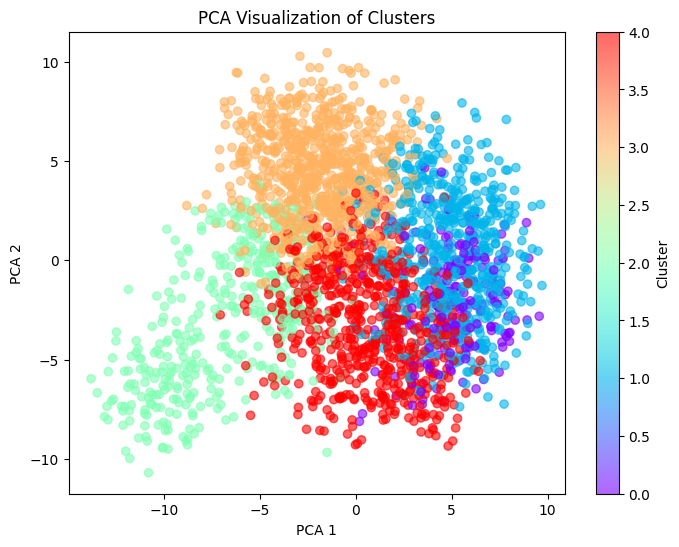

In [80]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='rainbow', alpha=0.6)
plt.title("PCA Visualization of Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


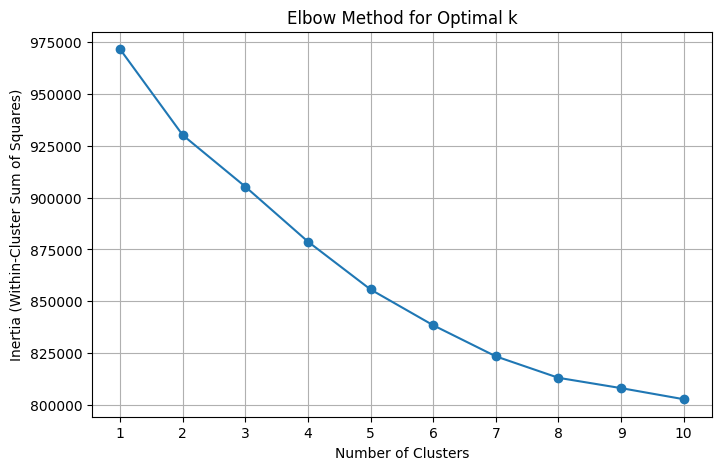

In [81]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
cluster_range = range(1, 11)  # Coba jumlah cluster dari 1 sampai 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# from kneed import KneeLocator

# kl = KneeLocator(cluster_range, inertias, curve="convex", direction="decreasing")
# optimal_k = kl.elbow
# print("Jumlah cluster optimal menurut Elbow Method:", optimal_k)



In [82]:
# buat k = 7
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)
print(df['cluster'].value_counts())

cluster
1    497
4    490
0    484
2    446
3    359
6    217
5    181
Name: count, dtype: int64


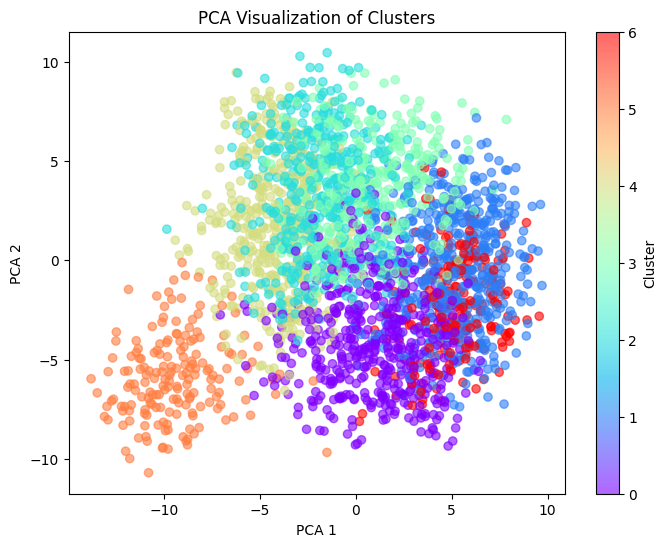

In [83]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='rainbow', alpha=0.6)
plt.title("PCA Visualization of Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


In [84]:
for i in range(n_clusters):
    print(f"\nCluster {i}")
    print(df[df['cluster'] == i][['judul']].head(10))


Cluster 0
                                                 judul
1    Pandemic Treaty: Ada Denda untuk Masyarakat Pe...
8    Materi Perang Dihapus dari Kurikulum? Kemenag:...
20   Ajakan untuk Tarik Uang sebelum Hal Buruk Terjadi
82   Trump dan Elon Musk Bertikai Sengit, Para Pega...
107  Kecelakaan Pesawat Adalah Bagian dari Agenda “...
131  Dokumentasi “Koalisi Militer Indonesia-Rusia d...
136  Eks PM Ukraina Memprediksi Zelensky Akan Disin...
139  Pasukan Israel Bajak Kapal Kemanusiaan Gaza ya...
148  Saham Tesla Ambles 14% Buntut Perselisihan Don...
170      Indonesia Sangat Terbuka Diserang Negara Lain

Cluster 1
                                                 judul
27   Bom Waktu Hubungan Prabowo-Gibran, Relasi Kedu...
57   Ketik "Monyet Cukur Rambut" di Google, Muncul ...
66   Tesla Model S Jadi Korban Perang Donald Trump ...
150  Beredar Kabar BJ Habibie Meninggal, Melanie Su...
215  Kejam Sekali, Hoax tentang Meninggalnya BJ Hab...
257  Viral Cuitan 'Sekolah yang Pinter Biar

In [85]:
from collections import Counter
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Siapkan stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Fungsi pembersih & tokenisasi
def tokenize(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # hilangkan angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # hilangkan tanda baca
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

# Misalnya pakai kolom 'isi' untuk dianalisis
for cluster_id in sorted(df['cluster'].unique()):
    texts = df[df['cluster'] == cluster_id]['isi'].dropna().tolist()
    all_tokens = []
    for text in texts:
        all_tokens.extend(tokenize(text))

    counter = Counter(all_tokens)
    top_words = counter.most_common(10)

    print(f"\n🟦 Cluster {cluster_id} - Top 10 Words:")
    for word, freq in top_words:
        print(f"{word}: {freq}")



🟦 Cluster 0 - Top 10 Words:
orang: 351
memiliki: 339
indonesia: 301
harga: 246
salah: 223
video: 217
dunia: 209
usd: 207
advertisement: 181
negara: 180

🟦 Cluster 1 - Top 10 Words:
orang: 275
sang: 204
habibie: 198
indonesia: 189
video: 180
film: 171
rumah: 165
salah: 164
memiliki: 149
foto: 143


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



🟦 Cluster 2 - Top 10 Words:
kpk: 500
indonesia: 401
pemerintah: 328
jakarta: 326
presiden: 289
dpr: 278
korupsi: 218
negara: 217
jokowi: 210
masyarakat: 205

🟦 Cluster 3 - Top 10 Words:
korban: 401
warga: 227
polisi: 223
video: 211
jalan: 197
rumah: 192
orang: 189
jakarta: 188
pelaku: 173
kota: 146

🟦 Cluster 4 - Top 10 Words:
video: 1519
unggahan: 963
fakta: 886
akun: 856
narasi: 711
konten: 663
turnbackhoax: 564
arsip: 522
pemeriksaan: 494
klaim: 487

🟦 Cluster 5 - Top 10 Words:
akun: 496
unggahan: 471
tautan: 462
resmi: 338
fakta: 327
laman: 306
informasi: 300
turnbackhoax: 263
berisi: 232
facebook: 220

🟦 Cluster 6 - Top 10 Words:
pemain: 327
laga: 281
tim: 243
indonesia: 242
gol: 217
pertandingan: 205
timnas: 204
liga: 193
piala: 162
dunia: 162
